In [1]:
'''
【项目08】  电商打折套路解析

作业要求
1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
要求：
① 计算得到：商品总数、品牌总数
② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）
③ 未参与双十一当天活动的商品，在双十一之后的去向如何？
④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
   * 用bokeh绘制柱状图表示
提示：
① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称
   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）
② 数据的“店名”字段为品牌的唯一标识
③ 按照商品销售节奏分类，我们可以将商品分为7类
   A. 11.11前后及当天都在售 → 一直在售
   B. 11.11之后停止销售 → 双十一后停止销售
   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   D. 11.11开始销售且当天停止 → 仅双十一当天有售
   E. 11.5 - 11.10 → 双十一前停止销售
   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   G. 11.12开始销售 → 双十一后上架
④ 未参与双十一当天活动的商品，可能有四种情况：
   con1 → 暂时下架（F）
   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')
   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
   con4 → 彻底下架（E中部分数据），可忽略
⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）
   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少
   
2、哪些商品真的在打折呢？
要求：
① 针对每个商品，评估其打折的情况
② 针对在打折的商品，其折扣率是多少
   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
③ 按照品牌分析，不同品牌的打折力度
   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度
提示：
① 打折情况评估方法：
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
   data[['id','price','date']].groupby(['id','price']).min()
   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
③ 折扣率 = 双十一当天价格 / 双十一之前价格
④ 作图过程中，清除掉折扣率大于95%的数据

3、商家营销套路挖掘？
要求：
① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路
   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数
提示：
① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据
② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路

'''

"\n【项目08】  电商打折套路解析\n\n作业要求\n1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”\n要求：\n① 计算得到：商品总数、品牌总数\n② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）\n③ 未参与双十一当天活动的商品，在双十一之后的去向如何？\n④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？\n   * 用bokeh绘制柱状图表示\n提示：\n① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称\n   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）\n② 数据的“店名”字段为品牌的唯一标识\n③ 按照商品销售节奏分类，我们可以将商品分为7类\n   A. 11.11前后及当天都在售 → 一直在售\n   B. 11.11之后停止销售 → 双十一后停止销售\n   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售\n   D. 11.11开始销售且当天停止 → 仅双十一当天有售\n   E. 11.5 - 11.10 → 双十一前停止销售\n   F. 仅11.11当天停止销售 → 仅双十一当天停止销售\n   G. 11.12开始销售 → 双十一后上架\n④ 未参与双十一当天活动的商品，可能有四种情况：\n   con1 → 暂时下架（F）\n   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')\n   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）\n   con4 → 彻底下架（E中部分数据），可忽略\n⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）\n   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少\n   \n2、哪些商品真的在打折呢？\n要求：\n① 针对每个商品，评估其打折的情况\n② 针对在打折的商品，其折扣率是多少\n   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量\n③ 按照品牌分析，不同品牌的打折力

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
% matplotlib inline


import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
from bokeh.palettes import brewer
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

Loading BokehJS ...

商品总数为：3502,品牌总数为：22
参加双十一当天的商品数量为：2336,其商品数量占商品数量总数量的66.70%,未参加双十一活动商品数量占比为33.30%
未参加双十一的产品类别为E，F，G类，它们的去向分别是：
暂时下架商品的数量为242个，重新上架商品的数据量为425个，预售商品的数据量为396个，彻底下架的数据量为20个
真正参加双十一的商品数量为：2732，占比为78.01%
      预售数量  双十一当天售卖商品数量  shunxu
店名                             
悦诗风吟    60         2709    2769
佰草集    182         1840    2022
欧莱雅     81         1644    1725
雅诗兰黛   239         1392    1631
倩碧     282         1304    1586
妮维雅     78         1189    1267
美加净      6         1217    1223
欧珀莱    110          991    1101
娇兰     208          805    1013
兰蔻      69          917     986
相宜本草    72          844     916
自然堂     48          817     865
兰芝      24          828     852
美宝莲    114          619     733
玉兰油     90          588     678
资生堂    148          479     627
薇姿     132          475     607
植村秀     80          508     588
雅漾      47          540     587
雪花秀     44          434     478
SKII    90          342     432
蜜丝佛陀    92          327     419


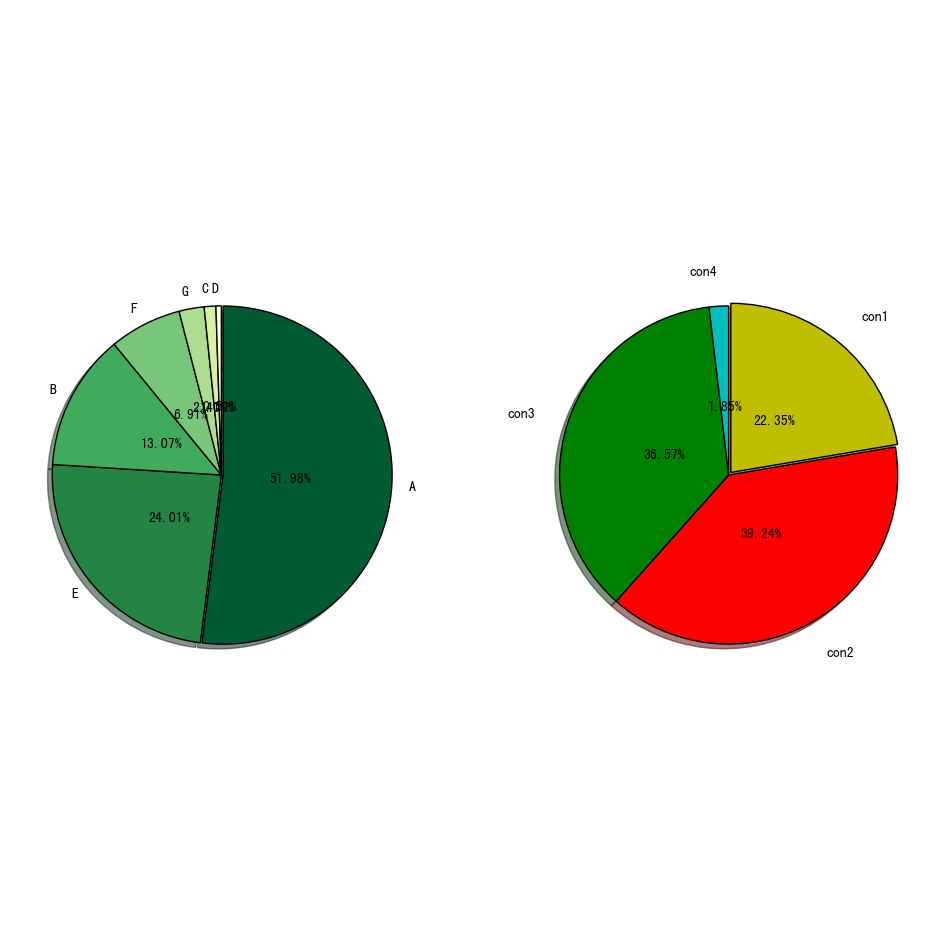

In [76]:
os.chdir(r'C:\Users\acer\Documents\Tencent Files\1970237873\FileRecv\项目08电商打折套路解析')
df1 = pd.read_excel('双十一淘宝美妆数据.xlsx',sheetname = 0,index_col=0)  
df1['date'] = df1.index.day   # 提取日期
#读取数据

id_11 = df1['id'][df1['date'] == 11]    #提取双十一当天在售的商品id
df2 = pd.DataFrame({'双十一当天是否售卖':True},index=id_11)
sp_sum = len(df1['id'].unique())       # 商品的总数
pp_sum = len(df1['店名'].unique())    #品牌的总数
sp_11 = len(df2)                   # 参加双十一的商品数量
sp_11_per = sp_11 / sp_sum * 100  # 参加双十一的商品数量占比
print('商品总数为：%.0f,品牌总数为：%.0f'%(sp_sum,pp_sum))
print('参加双十一当天的商品数量为：%.0f,其商品数量占商品数量总数量的%.2f%%,未参加双十一活动商品数量占比为%.2f%%'%(sp_11,sp_11_per,100-sp_11_per))


df3 = df[['id','date']].groupby('id').agg(['min','max'])['date']            # 提取商品售卖的开始日期与截止日期
df4 = pd.merge(df3,df2,left_index=True,right_index=True,how = 'outer')     #合并数据
df4['双十一当天是否售卖'].fillna(False,inplace=True)                      # 填充空值
#df4.head(100)
df4['type'] = '待分类'
df4['type'][(df4['min'] <11)&(df4['max']>11)&(df4['双十一当天是否售卖']==True)] = 'A'  #  A类：11.11前后及当天都在售 → 一直在售
df4['type'][(df4['min'] <11)&(df4['max']==11)] = 'B'                                    #  B类：11.11之后停止销售 → 双十一后停止销售
df4['type'][(df4['min'] ==11)&(df4['max']>11)] = 'C'                                    #  C类：11.11开始销售并当天不停止 → 双十一当天上架并持续在售
df4['type'][(df4['min'] ==11)&(df4['max']==11)] = 'D'                                   #  D类：11.11开始销售且当天停止 → 仅双十一当天有售
df4['type'][df4['双十一当天是否售卖']== False] = 'F'                                   #  F类：仅11.11当天停止销售 → 仅双十一当天停止销售
df4['type'][df4['max'] < 11] = 'E'                                                      #  E类：11.5 - 11.10 → 双十一前停止销售
df4['type'][df4['min'] > 11] = 'G'                                                    # G类：11.12开始销售 → 双十一后上架
# print(df4.head(100))
s = df4['type'].value_counts()      # 统计各类商品数量
df5 = pd.DataFrame({'num':s},index=s.index)
df5.index.name = '商品类别'
df5['num_p'] = (df5['num'] / df5['num'].sum()) * 100   # 计算各类商品所占的百分比
#print(df5)
fig,axes = plt.subplots(1,2,figsize=(12,12))
colors = brewer['YlGn'][7]
axes[0].axis('equal')
axes[0].pie(df5['num_p'],
        explode = [0.01,0,0,0,0,0,0],
       labels = df5.index,
       colors = colors,
       autopct = '%.2f%%',
        pctdistance = 0.4,
       labeldistance = 1.1,
       shadow = True,
        startangle =90,
        radius = 1,
        frame = False,
        counterclock = False
       )
# 做出饼图


df7 = pd.merge(df1[['id','title','店名','date']],df4[['type','双十一当天是否售卖']],right_index=True,left_on='id',how = 'outer') 
#  con1 → 暂时下架（F）,计算其数量
con1 = len(df7[df7['type']=='F']['id'].unique())

#  con2 → 重新上架（E):数据中同一个id可能有不同title，“换个马甲重新上架”
df8 = (df7[df7['type'] == 'E'])[(df7[df7['type'] == 'E'])['title'].str.contains('预售')==False]   #筛选出E类产品中不含预售字样的商品
s1 = df8['id'].value_counts()               # 计算同一id出现的次数
con2 = len(s1[s1 != 1]) 

# con4 → 彻底下架
con4 = len(s1[s1 == 1])          # 则不含预售商品字样且id只出现一次的商品即属于第四类情况

# con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
s2 = (df7[df7['type'] == 'E'])[(df7[df7['type'] == 'E'])['title'].str.contains('预售')]['id'].value_counts()      # 筛选E中含有‘预售’字样
con3 = len(s2)
print('未参加双十一的产品类别为E，F，G类，它们的去向分别是：\n暂时下架商品的数量为%i个，重新上架商品的数据量为%i个，预售商品的数据量为%i个，彻底下架的数据量为%i个'%(con1,con2,con3,con4))
print('真正参加双十一的商品数量为：%i，占比为%.2f%%'%(sp_11 + con3,(sp_11 + con3)/sp_sum*100))

df9 = pd.DataFrame({'con1':con1,'con2':con2,'con3':con3,'con4':con4},index = ['数量']).T
df9['percent'] = df9['数量'] / df9['数量'].sum() * 100
plt.axis('equal')
axes[1].pie(df9['percent'],
        explode = [0.02,0,0,0],
       labels = df9.index,
       colors = ['y','r','g','c'],
       autopct = '%.2f%%',
        pctdistance = 0.4,
       labeldistance = 1.2,
       shadow = True,
        startangle =90,
        radius = 1,
        frame = False,
        counterclock = False
       )
# 绘制四种情况的占比情况


from bokeh.core.properties import value
# 导入value模块

# 筛选出E类产品中含'预售'字样的商品
df9 = (df7[df7['type'] == 'E'])[(df7[df7['type'] == 'E'])['title'].str.contains('预售')]
df11 = df9[['id','店名']].groupby('店名').count()             # 分组
df11.columns = ['预售数量']
# print(df11)
df12 = df7[df7['双十一当天是否售卖'] == True ]               # 筛选出双十一当天售卖的所有产品
df13 = df12[['id','店名']].groupby('店名').count()           #进行品牌分类
df13.columns = ['双十一当天售卖商品数量']
#print(df13)
df14 = pd.merge(df11,df13,right_index=True,left_index=True)  # 合并数据
df14['shunxu'] = df14['双十一当天售卖商品数量'] + df14['预售数量']
df14= df14.sort(columns = 'shunxu',ascending=False)
#print(df14)

pinpai  = df14.index.tolist()               # 品牌名
spsl = ['双十一当天售卖商品数量','预售数量']
data = {'pinpai':df14.index.tolist(),
       '双十一当天售卖商品数量':df14['双十一当天售卖商品数量'].tolist(),
       '预售数量':df14['预售数量'].tolist()}
source = ColumnDataSource(data=data)
colors = ['blue','red']
p = figure(x_range=pinpai, plot_height=400,plot_width = 1000, title="各个品牌参与双十一活动的商品数量分布")
renderers = p.vbar_stack(spsl,          # 设置堆叠值
                         x='pinpai',     # 设置x坐标
                         source=source,
                         width=0.8, color=colors,
                         alpha=0.5,
                         legend=[value(x) for x in spsl], name=spsl,
                         )

p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_right"
p.legend.orientation = "horizontal"


show(p)

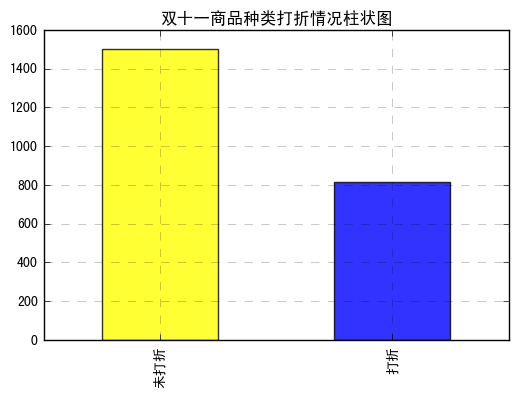

In [92]:
# 第二大题

os.chdir(r'C:\Users\acer\Documents\Tencent Files\1970237873\FileRecv\项目08电商打折套路解析')
df = pd.read_excel('双十一淘宝美妆数据.xlsx',sheetname = 0,index_col=0)  
df['date'] = df.index.day 
df1 = df[df['date'] != 11]  # 提取出不是双十一售卖的产品
df2 = df[df['date'] == 11]
df3 = df1[['id','price','店名']].groupby(['id','店名']).agg(['min','max'])  # 计算非双十一时商品的最高价和最低价
df3.columns = ['非双十一最低价','非双十一最高价']      
# print(df3.head(100))
df4 = df2[['id','price','店名']].groupby(['id','店名']).agg(['min'])   # 计算双十一时商品的价格
df4.columns = ['双十一价格']  
#print(df4.head(200))
df5 = pd.merge(df3,df4,right_index=True,left_index=True,how='inner') # 合并数据
df5['商品是否打折'] = False
df5['商品是否打折'][(df5['双十一价格'] <= df5['非双十一最低价'])&(df5['双十一价格']<df5['非双十一最高价'])] = True   # 筛选出打折的商品
#print(df5.head())
s = df5['商品是否打折'].value_counts()  # 对商品打折和未打折的数量进行统计
s.index = ['未打折','打折']
s.plot(kind='bar',color = ['yellow','blue'],alpha=0.8)
plt.title('双十一商品种类打折情况柱状图')
plt.grid(linestyle = '--',alpha = 0.3)

df6 = df5[df5['商品是否打折'] == True]
df6['折扣率'] = df6['双十一价格'] / df6['非双十一最高价']   # 计算打折商品的打折率
df6 = df6[df6['折扣率'] <= 0.95]    # 筛选折扣率小于等于0.95的商品
bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
s1 = pd.cut(df6['折扣率'],bins,include_lowest=True)    # 对折扣率进行范围划分
df6['折扣率范围'] = s1
df7 = df6[['折扣率范围','折扣率']].groupby('折扣率范围').count() # 将折扣率范围进行分类并计数
df7.columns = ['个数']
df7['percent'] = df7['个数'] / df7['个数'].sum()
# print(df7.head())

index = df7.index.tolist()
source = ColumnDataSource(data = df7)
p = figure(plot_height = 300,plot_width = 800,x_range = index)
p.line(x='折扣率范围',y='percent',source = source,     # 设置x，y值, source → 数据源
       line_width=1, line_alpha = 0.8, line_color = 'black',line_dash = [10,4])   # 线型基本设置
# 绘制折线图
p.circle(x='折扣率范围',y='percent',source = source, 
         size = 5,color = 'red',alpha = 0.8)

p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_right"
p.legend.orientation = "horizontal"
show(p)


In [93]:
from bokeh.models import HoverTool
# 用于设置显示标签内容
from bokeh.transform import jitter
from bokeh.models.annotations import Span
# 导入Span模块

df8 = df6.reset_index(level = 1)  #重设df6
df8['id'] = df8.index
df9 = df8[['店名','折扣率','非双十一最高价','id']].groupby(['店名','折扣率','id']).count()

df9.dropna(inplace=True)  # 去除空值
df9.columns = ['商品数量']
df99 = df9.copy()
df9.reset_index(level=1,inplace=True)
df9.reset_index(level=1,inplace=True)
#print(df9.head(100))

# 绘制散点图
index = df9.index.drop_duplicates().tolist()
source = ColumnDataSource(data = df9)
hover = HoverTool(tooltips=[
                            ("折扣率", "$x")
                        ])
p1 = figure(plot_width = 800,plot_height = 800,y_range = index,title = '不同品牌折扣率情况' ,
           tools=[hover,'box_select,reset,wheel_zoom,pan,crosshair'])
p1.circle(x='折扣率',y=jitter('店名', width=0.1, range=p1.y_range),source = source, 
         size = 3,color = 'blue',alpha = 0.5)


show(p1)

In [95]:
# 3、商家营销套路挖掘
df10 = df5.reset_index(level=1)
df11 = pd.merge(df[['店名','title','id']],df10[['双十一价格','商品是否打折']],left_on = 'id',right_index=True,how='inner')
df12 = df11[['id','店名','商品是否打折']].groupby(['店名','商品是否打折']).count()
df12.columns = ['商品数量']
df13 = df12.unstack().T.reset_index(level=1).T
df13.fillna(0,inplace=True)
df13.drop('商品是否打折',axis=0,inplace=True)
df13.columns = ['未打折商品数量','打折商品数量']    # 统计品牌商商品打折情况
df13['spsl'] = df13['未打折商品数量'] + df13['打折商品数量']   # 统计各个品牌的商品数量
df13['折扣商品比例'] = df13['打折商品数量'] / df13['spsl']

df14 = df99.reset_index(level=0) 
df14.reset_index(level=0,inplace=True) 
df15 = df14[['折扣率','店名']].groupby('店名').mean()  # 计算各个品牌的折扣力度
df15.columns = ['折扣力度']
df16 = pd.merge(df13,df15,left_index=True,right_index=True)  # 合并数据
df16.index.name = 'brand'
# print(df16)
zksp_m = df16['折扣商品比例'].mean() # 计算折扣商品比例的平均值
zkld_m = df16['折扣力度'].mean()   # 计算折扣力度的平均值
  
source = ColumnDataSource(df16)
hover1 = HoverTool(tooltips=[
                            ("品牌","@brand"),
                            ("参与商品打折比例", "$x"),
                            ("折扣力度", "$y"),
                            ("商品总数","@spsl")
                        ])
y_line = Span(location=zkld_m,           # 设置位置，对应坐标值
             dimension='width',      
             line_color='blue', line_width=1,line_dash ='dashed'  # 设置线颜色、线宽
            )
x_line = Span(location=zksp_m,           # 设置位置，对应坐标值
             dimension='height',      
             line_color='blue', line_width=1,line_dash ='dashed'  # 设置线颜色、线宽
            )
p2 = figure(plot_width = 600,plot_height = 400,title = '各个品牌打折套路解析' ,
          tools=[hover1,'box_select,reset,wheel_zoom,pan,crosshair'])  #绘制
p2.circle_cross(x='折扣商品比例',y='折扣力度',source=source,
         size = df16['spsl']/40,color = 'red',alpha = 0.5)
p2.add_layout(x_line)
p2.add_layout(y_line)
p2.text(0.1,0.8,text = ['少量小打折'])
p2.text(0.1,0.52,text = ['少量大打折'])
p2.text(0.7,0.8,text = ['大量小打折'])
p2.text(0.7,0.52,text = ['大量大打折'])
p2.background_fill_color = "beige"    # 绘图空间背景颜色
p2.background_fill_alpha = 0.5        # 绘图空间背景透明度
show(p2)

'''
结论：
少量小打折：包括雅诗兰黛、娇兰、兰蔻、薇姿、玉兰油等共五个品牌，打折商品很少，且打折力度都比较小。
少量大打折：包括悦诗风吟、兰芝、欧珀莱等三个品牌，该类品牌的打折商品较少，但折扣力度较大。
大量小打折：包括妮维雅、美宝莲、蜜丝佛陀、美加净、玉兰油等5个品牌，该类型有半数以上的商品都参与了打折活动，但折扣力度并不大。
大量大打折：包括相宜本草、佰草集、自然堂等三个品牌，这些品牌有90%以上的商品参与了折扣活动，而且折扣力度很大。
'''


'\n结论：\n少量小打折：包括雅诗兰黛、娇兰、兰蔻、薇姿、玉兰油等共五个品牌，打折商品很少，且打折力度都比较小。\n少量大打折：包括悦诗风吟、兰芝、欧珀莱等三个品牌，该类品牌的打折商品较少，但折扣力度较大。\n大量小打折：包括妮维雅、美宝莲、蜜丝佛陀、美加净、玉兰油等5个品牌，该类型有半数以上的商品都参与了打折活动，但折扣力度并不大。\n大量大打折：包括相宜本草、佰草集、自然堂等三个品牌，这些品牌有90%以上的商品参与了折扣活动，而且折扣力度很大。\n'